# Imports

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from dotenv import load_dotenv
from openai import OpenAI
import os
from tqdm.notebook import tqdm
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from transformers import pipeline

# Data

In [34]:
df = pd.read_csv("amazon_reviews.csv")
df.shape

(4915, 12)

In [35]:
df.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,NaN,4.0,No issues.,2014-07-23,138,0,0,0,0,0.0,0.0
1,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0
2,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0
3,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0
4,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0


# Preprocess

In [38]:
def preprocess(text):
    """
    Preprocesses the given text by removing duplicate symbols and extra whitespaces.
    
    Args:
        text (str): The input text to be preprocessed.
    
    Returns:
        str: The preprocessed text.
    """
    # Remove duplicate symbols.
    text = re.sub(r'([^\w\s])\1+', r'\1', text)
    
    # Remove extra whitespaces.
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Check if the string length is 1, if so, return an empty string.
    if len(text) == 1:
        return ""
    return text

We need to ensure that the `reviewText` column does not contain any null values, as we are only interested in text data in string format.

In [39]:
if df['reviewText'].isnull().any():
    print(f"Attention: There are {df['reviewText'].isnull().sum()} null values in the column '{'reviewText'}'.")
else:
    print("No null values found.")

Attention: There are 1 null values in the column 'reviewText'.


In [40]:
df.dropna(subset=['reviewText'], inplace=True)
df.shape

(4914, 12)

In [43]:
non_string_values = df[~df['reviewText'].apply(lambda x: isinstance(x, str))]

if not non_string_values.empty:
    print(f"Attention: There are {len(non_string_values)} values that are not strings in the column '{'reviewText'}'.")
    print("Examples of non-string values:")
    print(non_string_values['reviewText'].head())  # Displays some examples for inspection
else:
    print("All values in the column are strings.")

All values in the column are strings.


In [42]:
df['processed_comment'] = df['reviewText'].apply(preprocess) # Applying the preprocess function to each comment

# EDA

## Rating 

First, I'll investigate if there is any bias in the ratings. This is important for the sentiment analysis check since we can expect a correlation between sentiments and ratings.

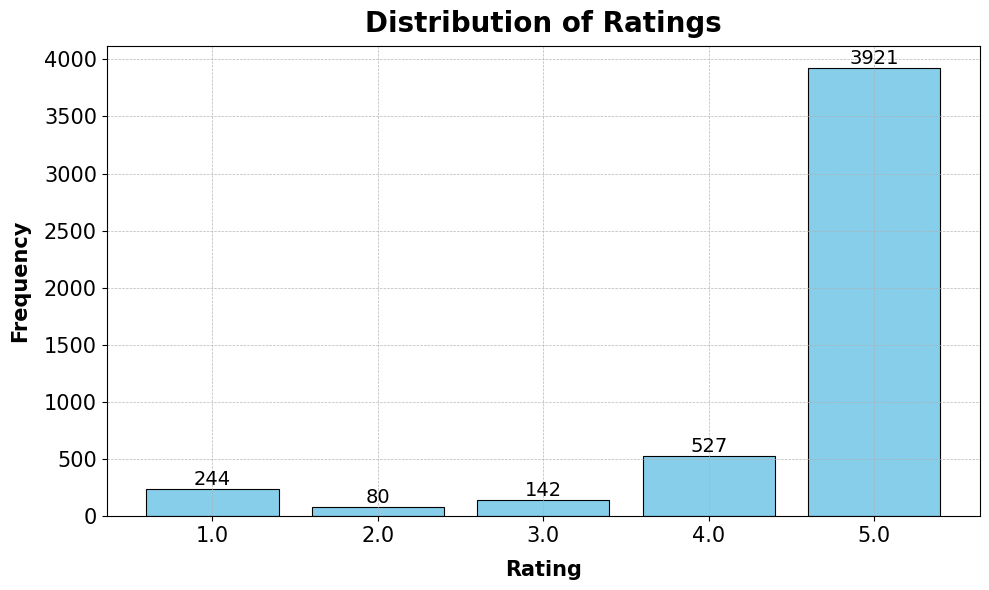

In [6]:
#First plot is to see if our dataset have a bias for a rate (overall)

rating_counts = df['overall'].value_counts().sort_index()


plt.figure(figsize=(10, 6))
bars = plt.bar(rating_counts.index, rating_counts, color='skyblue', edgecolor='black', linewidth=0.8)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, int(yval), ha='center', va='bottom', fontsize=14)

plt.xlabel('Rating', fontsize=15, labelpad=10, fontweight='bold')
plt.ylabel('Frequency', fontsize=15, labelpad=10, fontweight='bold')
plt.title('Distribution of Ratings', fontsize=20, pad=10, fontweight='bold')
plt.xticks(ticks=rating_counts.index, labels=rating_counts.index, fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.9)
plt.tight_layout()
plt.show()

## Trend

And import trend to considerar, is that people who give lower ratings are more likely to write comments and this comments tend to be longer.

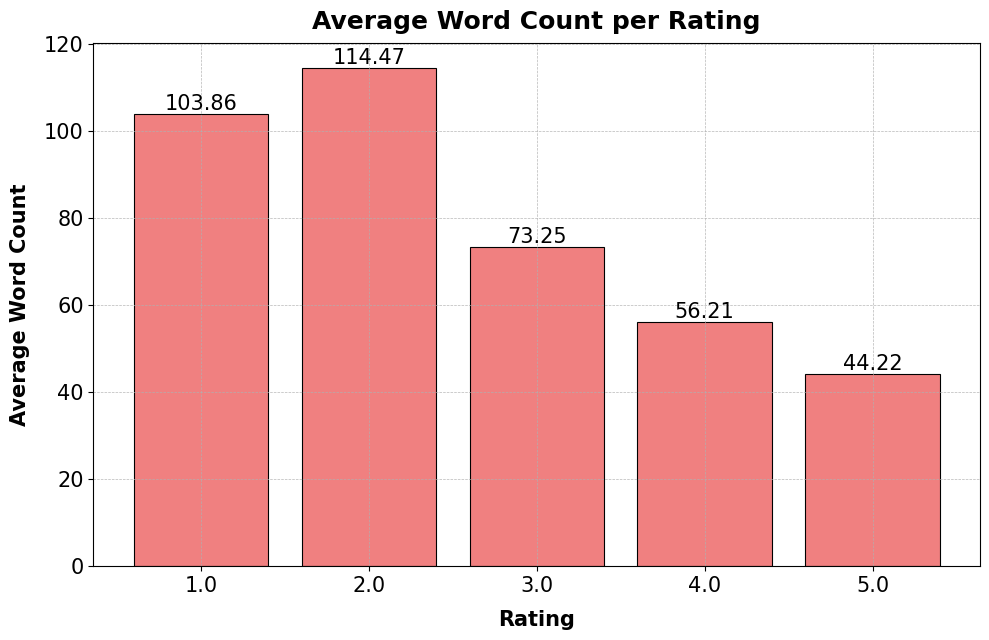

In [7]:
# Using split to calculate the number of words in each comment
df['Word Count'] = df['reviewText'].apply(lambda x: len(x.split()))

# Calculating the average word count per rating
average_word_count = df.groupby('overall')['Word Count'].mean()
average_word_count_df = average_word_count.reset_index()

# Plot to visualize the average word count per rating
plt.figure(figsize=(10, 6.5))
bars = plt.bar(average_word_count.index, average_word_count, color='lightcoral', edgecolor='black', linewidth=0.8)

# Adding text labels above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', fontsize=15)

plt.xlabel('Rating', fontsize=15, labelpad=10, fontweight='bold')
plt.ylabel('Average Word Count', fontsize=15, labelpad=10, fontweight='bold')
plt.title('Average Word Count per Rating', fontsize=18, pad=10, fontweight='bold')
plt.xticks(ticks=average_word_count.index, labels=average_word_count_df['overall'], fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.9)
plt.tight_layout()
plt.show()

This confirms our expectation: 
- lower ratings (1 and 2) tend to have a higher average word count, 
- higher ratings have fewer words on average. 

This suggests that more satisfied customers are less likely to leave lengthy comments.

# Sentiment Analysis

In [10]:
tqdm.pandas(desc="Processing sentiments") # Adds a progress bar when applying the lambda function

In [11]:
client = OpenAI(
    #load_dotenv()
    api_key=os.getenv('API_KEY'),
)

chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": "Say this is a test",
        }
    ],
    model="gpt-4o",
)

In [12]:
def get_sentiment(text):
    try:
        completion = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are a sentiment analysis assistant. Your task is to classify the sentiment of a given text as 'positive', 'negative', or 'neutral' based on its content."},
            {
                "role": "user",
                "content": f"The following text is feedback from a user answering the question: 'Do you have any feedback or suggestions?'. Please classify its sentiment as 'positive', 'negative', or 'neutral': '{text}'."
            }
        ]
    )
        match = re.search(r"negative|neutral|positive", completion.choices[0].message.content.strip(), re.IGNORECASE)
        if match:
            return match.group(0).lower()
        else:
            print(f"No valid sentiment found in response: {completion.choices[0].message.content.strip()}")
            return "undefined"
        
    except Exception as e:
        print(f"Error processing text: '{text}' | Exception: {e}")
        return "Error"

In [13]:
df['sentiment'] = df['processed_comment'].progress_apply(get_sentiment)

#this part get 40min to finish, so I saved the dataframe and read again.

Processing sentiments:   0%|          | 0/4914 [00:00<?, ?it/s]

In [15]:
df.to_csv("sentiment_classified.csv")

In [44]:
df = pd.read_csv("sentiment_classified.csv")

In [45]:
sentiment_counts = df['sentiment'].value_counts()
sentiment_labels = sentiment_counts.index.tolist()
sentiment_values = sentiment_counts.values.tolist()

In [46]:
sentiment_labels = ['positive', 'neutral', 'negative']

## Overall Sentiment

In [47]:
# This script visualizes sentiment analysis results using two types of charts: a bar chart and a pie chart.
# The first chart is a grouped bar chart that displays sentiment counts for each category (positive, neutral, negative).
# The second chart is a pie chart showing the proportion of each sentiment category.
# Both charts use custom colors for consistency across visualizations.

# Colors are defined for each sentiment (positive, neutral, and negative) to visually distinguish the categories.
colors = {'positive': '#6BCD53', 'neutral': 'orange', 'negative': '#FF6347'}

# Sorting the colors according to the sentiment labels for consistent application in both charts.
sorted_colors = [colors[label] for label in sentiment_labels]

# Creating a layout with two subplots: one for the bar chart and one for the pie chart.
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'bar'}, {'type':'domain'}]])

# Adding a bar chart to the first subplot, showing sentiment counts with the text labels inside each bar.
# The bars are colored according to the sentiment, and the text is positioned for clear visibility.
fig.add_trace(
    go.Bar(
        x=sentiment_labels, 
        y=sentiment_values, 
        marker_color=sorted_colors, 
        text=sentiment_values, 
        textposition='inside', 
        showlegend=False,
        hoverinfo='y',
        textfont=dict(size=18)
    ),
    row=1, col=1
)

# Adding a pie chart to the second subplot, representing the sentiment distribution as percentages.
# The pie chart has a hole in the center (donut chart), and the colors match those used in the bar chart.
fig.add_trace(
    go.Pie(
        labels=sentiment_labels, 
        values=sentiment_values, 
        hole=.4, 
        marker=dict(colors=sorted_colors), 
        hoverinfo='label+percent',
        textfont=dict(size=18)
    ),
    row=1, col=2
)

# Updating the layout to include a title, annotations, and overall chart dimensions.
# The title is centered, and annotations describe the two charts for clarity.
fig.update_layout(
    title_text='Sentiment Distributions',
    title_x=0.5,  # Center the main title
    title_font=dict(size=24),  # Increase the font size of the title
    annotations=[
        dict(text='Sentiment Count', x=0.11, y=1.1, xref='paper', yref='paper', showarrow=False, font=dict(size=20)),
        dict(text='Sentiment Percentage', x=0.92, y=1.1, xref='paper', yref='paper', showarrow=False, font=dict(size=20))
    ],
    width=1000,  # Set the width of the figure
    height=500   # Set the height of the figure
)

# Display the final combined visualization with the bar chart and pie chart side by side.
fig.show()


This was expected, since we saw that the higher values of Ratings are in rating 4 to 5, this means, very good rates.

But to confirme more clearly about that, we now go see a plot with the correlation between the rating and the sentiment.

## Correlation between sentiment and rating

In [15]:
# Step 1: Aggregate the data by 'Rating' and 'Sentiment' category
# The aggregation counts the number of occurrences of each sentiment for each rating category.
# This prepares the data for a grouped bar chart where we can compare sentiment distribution across ratings.
sentiment_by_rating = df.groupby(['overall', 'sentiment']).size().unstack(fill_value=0)

# Step 2: Extract the 'overall' rating categories and the 'sentiment' labels
# 'categories' (i.e., ratings) will serve as the x-axis values, while 'labels' will be used to define the groups of bars.
categories = sentiment_by_rating.index
labels = sentiment_by_rating.columns

# Step 3: Convert the DataFrame's sentiment counts into a list of numpy arrays
# Each array represents the counts of a particular sentiment (e.g., positive, neutral, negative) across all ratings.
# This step simplifies accessing the data for plotting in the bar chart.
data = [sentiment_by_rating[label].values for label in labels]

# Step 4: Define the width of each bar in the bar chart
bar_width = 0.25  # This controls the thickness of each bar in the grouped bar chart.

# Step 5: Calculate the x-axis positions for each group of bars
# 'r1' is the starting position for the first group of bars (negative sentiment).
# 'r2' is the starting position for the second group of bars (neutral sentiment), shifted by the bar width.
# 'r3' is for the third group (positive sentiment), also shifted accordingly.
r1 = np.arange(len(categories))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Step 6: Initialize the Plotly figure for the grouped bar chart
fig = go.Figure()

# Step 7: Add the first set of bars representing 'Negative' sentiment
fig.add_trace(go.Bar(
    x=r1,  # x-axis positions for negative sentiment bars
    y=data[0],  # The counts of negative sentiment
    name='Negative', 
    marker_color='#FF6347', 
    width=bar_width,  
    text=data[0],  # Display the count above each bar
    textposition='outside',  # Position the text above the bar
    textfont=dict(size=18) 
))

# Step 8: Add the second set of bars for 'Neutral' sentiment
fig.add_trace(go.Bar(
    x=r2,  # x-axis positions for neutral sentiment bars
    y=data[1],  # The counts of neutral sentiment
    name='Neutral',  
    marker_color='orange',  
    width=bar_width, 
    text=data[1],  # Show counts above each bar
    textposition='outside',  # Text positioned outside for clarity
    textfont=dict(size=18)  
))

# Step 9: Add the third set of bars for 'Positive' sentiment
fig.add_trace(go.Bar(
    x=r3,  # x-axis positions for positive sentiment bars
    y=data[2],  # The counts of positive sentiment
    name='Positive',  
    marker_color='#6BCD53',  
    width=bar_width, 
    text=data[2],  # Display counts above bars
    textposition='outside',  # Positioning text above the bar
    textfont=dict(size=18) 
))

# Step 10: Update the layout for visual clarity and aesthetics
fig.update_layout(
    title='Sentiment Distribution by Rating',  # Title of the entire chart
    xaxis=dict(
        title='Rating',  
        title_font={"size": 20}, 
        tickmode='array',  
        tickvals=[r + bar_width for r in range(len(r1))],  
        ticktext=[str(rating) for rating in categories], 
        tickfont={"size": 20},  
        range=[-0.2, len(categories) - 0.98 + bar_width * 3]  
    ),
    yaxis=dict(
        title='Count', 
        title_font={"size": 20},  
        tickfont={"size": 20}  
    ),
    barmode='group',  
    margin=dict(l=40, r=40, t=40, b=40),  
    legend_title="",  
    legend_title_font={"size": 20},  
    legend=dict(
        font=dict(size=20)  
    ),
    width=1200,  
    height=700  
)

# Step 11: Display the final chart
fig.show()


As observed, there is a strong concentration of positive sentiments in the 5-star ratings, with a clear decline as the ratings decrease. 

This trend indicates that the sentiment classification aligns well with the expected pattern, suggesting the model is correctly associating higher ratings with more positive feedback and lower ratings with more negative sentiments. This consistency reinforces the accuracy of the sentiment analysis in capturing the relationship between customer satisfaction and rating.

# Topic Classification

For the topic classification, I will use a different Large Language Model (LLM) instead of OpenAI's models. The goal is to explore an alternative approach and demonstrate the use of another LLM.

The chosen model is DeBERTa Large, fine-tuned for Zero-Shot classification.

You can find the documentation here: [DeBERTa-v3-large-zeroshot-v2.0.](https://huggingface.co/MoritzLaurer/deberta-v3-large-zeroshot-v2.0)

## Approach

1. To enable Zero-Shot topic classification, I predefined general topics commonly found in feedback on platforms like Amazon. These include:
    - Price
    - Quality
    - Product functionality 
    - Compatibility with devices (e.g., SD cards, phones, and cameras)
    - Delivery Service

2. There are multiple ways to provide context to the model. I chose to offer a context that includes a brief summary of what each topic represents. This context will be referred to as feature descriptions.

In [48]:
features_description = {
    "Price": "Evaluation of the product's cost, whether it's considered affordable, expensive, or offers good value for the price paid compared to similar products.",

    "Quality": "Assessment of the product's durability, materials used, reliability, and overall build quality, including whether it meets customer expectations for longevity and performance.",

    "Product functionality": "How effectively the product fulfills its intended purpose, including performance, ease of use, and whether it works as described or expected by the customer.",

    "Compatibility with devices": "Whether the product functions well with other devices, such as SD cards, phones, or cameras, and how seamlessly it integrates or adapts to different systems.",

    "Delivery Service": "Customer experience regarding shipping speed, packaging quality, condition of the product upon arrival, and how reliable the delivery process was overall."
}

In [84]:
deberta_classifier = pipeline("zero-shot-classification",
                      model="MoritzLaurer/deberta-v3-large-zeroshot-v2.0",
                      batch_size=2)

All PyTorch model weights were used when initializing TFDebertaV2ForSequenceClassification.

All the weights of TFDebertaV2ForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDebertaV2ForSequenceClassification for predictions without further training.


In [93]:
def get_topics(text, input_features):
    """
    Classifies the provided text into topics or keywords based on the type of `input_features` (list or dict).

    Args:
        text (str): The text to be classified.
        classifier (callable): The classification model to be used.
        input_features (list or dict): A list of topics or a dictionary of categories with keywords.

    Returns:
        dict: A dictionary with topics or categories as keys and their respective confidences as values, summing up to 1 (100%).

        Example: {'usability': 0.8, 'performance': 0.1, 'quality': 0.05, 'error handling': 0.03, 'personal data': 0.02}
    """
   
    #TOPICS DESCRIPTIONS
    if isinstance(input_features, dict):
        # Create a reverse mapping from descriptions to category names
        description_to_category = {description: category for category, description in input_features.items()}
        descriptions = list(input_features.values())

        # Classify using the descriptions
        result = deberta_classifier(text, descriptions, multi_label=False)
        sorted_descriptions = sorted(zip(result['labels'], result['scores']), key=lambda x: x[1], reverse=True)

        # Map sorted descriptions back to categories and record scores
        category_scores = {}
        for description, score in sorted_descriptions:
            category = description_to_category[description]
            if category not in category_scores or score > category_scores[category]:
                category_scores[category] = score

            top_topic, top_score = max(category_scores.items(), key=lambda item: item[1])
  
        return top_topic
        
      
    
    else:
        raise ValueError("input_features must be either a list of topics or a dictionary of categories with descriptions.")

In [86]:
tqdm.pandas(desc="Processing topics") #Adds a progress bar 

In [ ]:
df['deberta_topics'] = df['processed_comment'].progress_apply(lambda x: get_topics(x, features_description))

In [91]:
df = pd.read_csv('topics_classified.csv')
df['deberta_topics'].value_counts()

deberta_topics
{'Product functionality': 0.45684757828712463, 'Quality': 0.3661511540412903, 'Delivery Service': 0.10858239233493805, 'Price': 0.04852854460477829, 'Compatibility with devices': 0.019890254363417625}      2
{'Product functionality': 0.6029630899429321, 'Compatibility with devices': 0.38434556126594543, 'Quality': 0.00840126071125269, 'Price': 0.00292277242988348, 'Delivery Service': 0.0013673709472641349}     2
{'Compatibility with devices': 0.508346438407898, 'Product functionality': 0.4657913148403168, 'Price': 0.020376738160848618, 'Quality': 0.004831202328205109, 'Delivery Service': 0.0006542039918713272}     1
{'Compatibility with devices': 0.5788255929946899, 'Product functionality': 0.28891316056251526, 'Price': 0.08484689891338348, 'Quality': 0.04143401235342026, 'Delivery Service': 0.0059804534539580345}     1
{'Product functionality': 0.5705971121788025, 'Price': 0.18475665152072906, 'Quality': 0.15520335733890533, 'Compatibility with devices': 0.0465122349560

In [92]:
def extract_top_topic(topic_dict, threshold):
    """
    Extracts the topic with the highest score that exceeds the specified threshold.
    If no topic reaches the threshold, returns None or an empty string.
    """
    if topic_dict:
        top_topic, top_score = max(topic_dict.items(), key=lambda item: item[1])
        if top_score >= threshold:
            return top_topic
    return None